In [1]:
import sys
sys.path.insert(0,'..')

In [2]:
import re
import numpy as np
from tempfile import TemporaryDirectory
from pathlib import Path
import os
from base import Mols
import time

gmx msd \
-mol \
-f traj.xtc \
-s box.gro 

In [31]:
def read_xvg(xvg_path):
    with open(xvg_path) as file:
        data = file.readlines()
    D_pattern = r'D\[\s*(?P<name>\w+)\s*\] = (?P<value>[\d\.]+)\s*\(\+\/\- (?P<var>.+)\s*\)\s*\(\s*(?P<unit>.+)\s*\)'
    time_pattern = r'fitted from time\s(?P<start>\d+)\s*to\s*(?P<end>\d+).*'

    result = {}
    MSD = []
    D_flag = False
    for line in data:
        D_line = re.search(
            string=line,
            pattern=D_pattern,
        )
        MSD_line = re.search(
            string=line,
            pattern=r'\s*(?P<time>\d+)\s*(?P<MSD>[\d\.]+).*',
        )
        fit = re.search(
            string=line,
            pattern=time_pattern,
        )
        if D_line:
            result['name'] = D_line.group('name')
            result['D'] = float(D_line.group('value'))
            result['Dvar'] = float(D_line.group('var'))
            result['name'] = D_line.group('name')
            value = D_line.group('unit')
            scale, unit = [part.strip() for part in value.split(' ')]
            result['scale'] = float(scale)
            result['unit'] = unit

            D_flag = True

        elif MSD_line and D_flag:
            time, msd = MSD_line.groups()
            MSD.append((int(time), float(msd)))
        elif fit:
            result['start'] = float(fit.group('start'))
            result['end'] = float(fit.group('end'))

    MSD = np.array(MSD)
    return result, MSD

In [40]:
compound = Mols.ocm
traj_path = Path('md.xtc').absolute()
system_path = Path('system.tpr').absolute()

with TemporaryDirectory() as temp_dir:
    temp_dir = Path(temp_dir)
    index_path = temp_dir / f'{compound.value}.ndx'
    xvg_path = temp_dir / f'{compound.value}.xvg'
    mol_path = temp_dir / f'{compound.value}_mol.xvg'

    command = f"""
gmx -quiet select \
-s {system_path} \
-select {compound.value} \
-on {index_path}

gmx -quiet msd \
-s {system_path} \
-f {traj_path} \
-n {index_path} \
-o {xvg_path}
"""
    os.system(command)
    time.sleep(1)
    data = read_xvg(xvg_path)

Reading file /home/base/Work_wsl/MolecularModeling/test/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file /home/base/Work_wsl/MolecularModeling/test/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Analyzed topology coordinates
Reading file /home/base/Work_wsl/MolecularModeling/test/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file /home/base/Work_wsl/MolecularModeling/test/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)

Select a group to calculate mean squared displacement for:
Group     0 (            OCM) has 11000 elements
There is one group in the index
Last frame        200 time  400.000   

Used 41 restart points spaced 10 ps over 400 ps



Fitting from 40 to 360 ps

D[       OCM] 0.0191 (+/- 0.0091) 1e-5 cm^2/s


In [8]:
read_xvg('msd.xvg')

({'name': 'OCM',
  'D': 0.0049,
  'Dvar': 0.0015,
  'scale': 1e-05,
  'unit': 'cm^2/s'},
 array([[0.00000e+00, 4.90000e-03],
        [0.00000e+00, 0.00000e+00],
        [2.00000e+00, 2.78573e-03],
        [4.00000e+00, 2.62755e-03],
        [6.00000e+00, 2.85154e-03],
        [8.00000e+00, 2.96092e-03],
        [1.00000e+01, 3.02023e-03],
        [1.20000e+01, 3.26815e-03],
        [1.40000e+01, 3.38277e-03],
        [1.60000e+01, 3.47275e-03],
        [1.80000e+01, 3.51970e-03],
        [2.00000e+01, 3.56719e-03],
        [2.20000e+01, 3.75211e-03],
        [2.40000e+01, 3.95246e-03],
        [2.60000e+01, 3.93756e-03],
        [2.80000e+01, 4.00631e-03],
        [3.00000e+01, 4.08575e-03],
        [3.20000e+01, 4.16784e-03],
        [3.40000e+01, 4.27796e-03],
        [3.60000e+01, 4.25104e-03],
        [3.80000e+01, 4.29772e-03],
        [4.00000e+01, 4.34099e-03],
        [4.20000e+01, 4.49596e-03],
        [4.40000e+01, 4.61413e-03],
        [4.60000e+01, 4.44364e-03],
        [4.

In [16]:
import matplotlib.pyplot as plt

In [42]:
0.0191*1e-5*24*60*60

0.016502400000000004

{'start': 40.0, 'end': 360.0, 'name': 'OCM', 'D': 0.0191, 'Dvar': 0.0091, 'scale': 1e-05, 'unit': 'cm^2/s'}


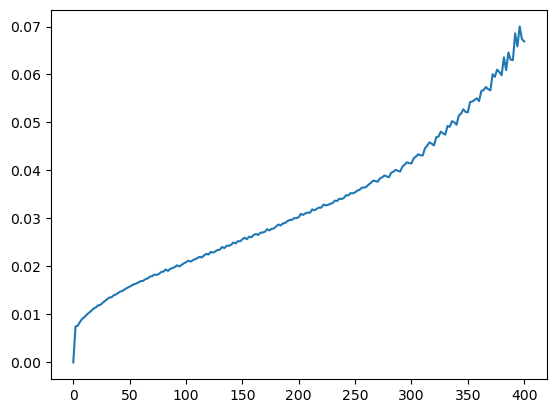

In [41]:
MSD=data[1]
plt.plot(MSD[:,0],MSD[:,1])
print(data[0])

{'start': 40.0, 'end': 360.0, 'name': 'OCM', 'D': 0.0092, 'Dvar': 0.005, 'scale': 1e-05, 'unit': 'cm^2/s'}


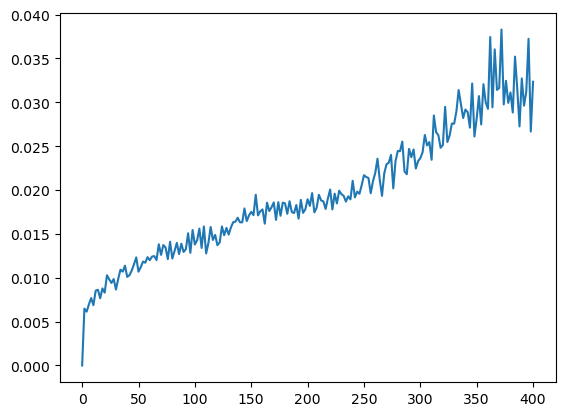

In [38]:
MSD=data[1]
plt.plot(MSD[:,0],MSD[:,1])
print(data[0])

In [19]:
from scipy.stats import linregress

In [20]:
regression = linregress(MSD[:,0],MSD[:,1])
D0 = regression.intercept
D = regression.slope